In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random

In [56]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
miceList = getMiceList(Files[0])
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 0#'Healthy'
    elif day<13:
        return 1#np.array([0,1,0])#'Acute' #day 1-13
    else:
        return 2#np.array([0,0,1])#'Chronic' #day 14-35

In [173]:
mTrain = ['0761', '1208', '1222', '1231', '1236', '7909' , '1793','4539',  '8430','1253']
mValidate = ['2976', '2980', '2981', '7584']
dataTrain = getData(Files[1],['trace'],period ='Pre',mice = mTrain)
dataValidate = getData(Files[1],['trace'],period ='Pre',mice = mValidate)
dataTest = getData(Files[1],['trace'],period ='Pre',mice = miceList[12:])

cleaning up trace data
cleaning up trace data
cleaning up trace data


In [236]:
l = list(dataTrain.keys())
random.shuffle(l)

l2 = list(dataValidate.keys())
random.shuffle(l2)

In [175]:
for ind in np.arange(1,13,2):
    print()
    del dataTrain['4539_day{ind:d}'.format(ind=ind)]#,dataValidate['7584_day{ind:d}'.format(ind=ind)]
    del dataTrain['7909_day{ind:d}'.format(ind=ind)]

In [237]:
def loadTrain_broken(data,l):
    while True: 
        for sess in l:
            m = sess[:4]
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            label = np.array([periodCalc(day)])
            sessdata = np.mean(data[sess]['trace']['dff'][:,:],axis=0)
            for win in range((np.max(sessdata.shape)-1200)//40):
                dataPoint = sessdata[win*40:(win*40)+1200]
                if dataPoint.shape[0]!=1200:
                    break
                yield (dataPoint[None,:,None].T,label)
    


In [239]:
def loadTrain(data,l):
#     while True:
    while True: 
        for win in range((12000-1200)//40):
            for sess in l:
                m = sess[:4]
                if sess[5] == 'B':
                    day = 0
                else:
                    day = int(re.findall(r'\d+',sess[5:])[0])
                label = np.array([periodCalc(day)])
                dataPoint = np.mean(data[sess]['trace']['dff'][:,win*40:(win*40)+1200],axis=0)
                if dataPoint.shape[0]!=1200:
                    continue
                yield (dataPoint[None,:,None].T,label)
    


In [252]:
def loadTest(data,l):
    for win in range((12000-1200)//40):
        for sess in l:
            m = sess[:4]
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            label = np.array([periodCalc(day)])
            dataPoint = np.mean(data[sess]['trace']['dff'][:,win*40:(win*40)+1200],axis=0)
            if dataPoint.shape[0]!=1200:
                continue
            yield (dataPoint[None,:,None].T,label)


In [25]:
def loadValidate(data,n):
    while True:
        for sess in data.keys():
            m = sess[:4]
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            label = np.array([periodCalc(day)])
            sessdata = np.mean(data[sess]['trace']['dff'][:,1200*n:],axis=0)
            for win in range(1200//20):
                dataPoint = sessdata[win*20:(win*20)+1200]
                if dataPoint.shape[0]!=1200:
                    break
                yield (dataPoint[None,:,None].T,label)
    


In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8501982781466560805
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7404313913767792312
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15375253182120616661
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [273]:
del model

In [274]:
model = Sequential()
model.add(Conv1D(10, (10), input_shape=(1200,1)))
model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(20, (15)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

# model.add(Conv2D(10, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(50,activation='relu'))
model.add(Dense(3,activation='softmax'))


In [ ]:
model = Sequential()
model.add(Conv1D(64, (10), input_shape=(1200,1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (15)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(32, (20)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(16, (15)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(32, (10)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))


# model.add(Conv2D(10, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(3,activation='softmax'))

# model.add(Conv2D(10, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))




In [275]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_53 (Conv1D)           (None, 1191, 10)          110       
_________________________________________________________________
activation_46 (Activation)   (None, 1191, 10)          0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 1177, 20)          3020      
_________________________________________________________________
activation_47 (Activation)   (None, 1177, 20)          0         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 588, 20)           0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 11760)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)              

In [286]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# history = model.fit(loadTrain(dataTrain,l), validation_data =loadTest(dataValidate,l2),epochs=800,batch_size=115,steps_per_epoch = 120)
# model.fit(loadTrain(dataValidate), epochs=500,batch_size=2579,steps_per_epoch = 120)
history = model.fit(loadTrain(dataTrain,l),validation_data =loadTest(dataValidate,l2),  epochs=50,batch_size=2579,steps_per_epoch = 120)

# print(dataP.shape)
# model.fit(loadData(data))


Epoch 1/50
120/120 [==============================] - 21s 178ms/step - loss: 0.8910 - accuracy: 0.5417 - val_loss: 1.2781 - val_accuracy: 0.3002
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8733 - accuracy: 0.5000
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8941 - accuracy: 0.5083
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8762 - accuracy: 0.5250
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8748 - accuracy: 0.5583
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8581 - accuracy: 0.5500
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8460 - accuracy: 0.5667
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8274 - accuracy: 0.5583
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8519 - accuracy: 0.6000
Epoch 10/50
120/120 [==============================] - 

In [284]:
## Saving the model
# model.save('E:\\caOnly_v1')
# model.save_weights("E:\\caOnly_v1_weights.h5")

INFO:tensorflow:Assets written to: E:\caOnly_v1\assets


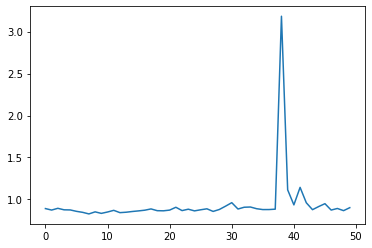

In [287]:
plt.plot(history.history['loss'])

In [282]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
pred = model.predict(loadTest(dataTrain,l)) 
# pred = pred/np.sum(pred)
pred = np.argmax(pred, axis = 1)
y = []
for ind,(label,dataP) in enumerate(loadTest(dataTrain,l)):
    y.append(dataP[0])


In [278]:
# x,y = loadTest(data)
score = model.evaluate(loadTest(dataTrain,l)) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


30820/30820 [==============================] - 51s 2ms/step - loss: 0.8675 - accuracy: 0.5518
Test loss: 0.8675424456596375
Test accuracy: 0.5517520904541016


In [289]:
# x,y = loadTest(data)
score = model.evaluate(loadTest(dataTest,dataTest.keys())) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


16011/16011 [==============================] - 26s 2ms/step - loss: 0.9511 - accuracy: 0.5722
Test loss: 0.951057493686676
Test accuracy: 0.5722315907478333


In [288]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
pred = model.predict(loadTest(dataTest,dataTest.keys())) 
# pred = pred/np.sum(pred)
pred = np.argmax(pred, axis = 1)
y = []
for ind,(label,dataP) in enumerate(loadTest(dataTest,dataTest.keys())):
    y.append(dataP[0])


2579


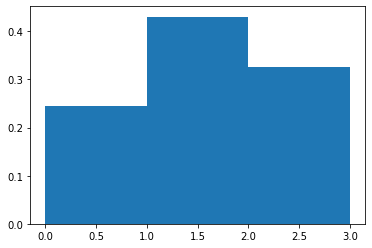

In [119]:
y = []
for ind,(label,dataP) in enumerate(loadTest(dataTrain)):
    y.append(dataP[0])
plt.hist(y,bins=[0,1,2,3],density=True)
print(ind)

2459


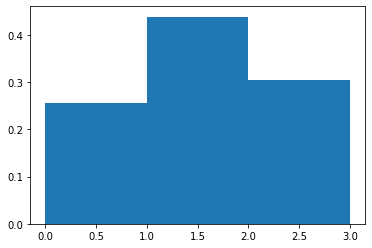

In [131]:
y = []
for ind,(label,dataP) in enumerate(loadTest(dataValidate)):
    y.append(dataP[0])
plt.hist(y,bins=[0,1,2,3],density=True)
print(ind)

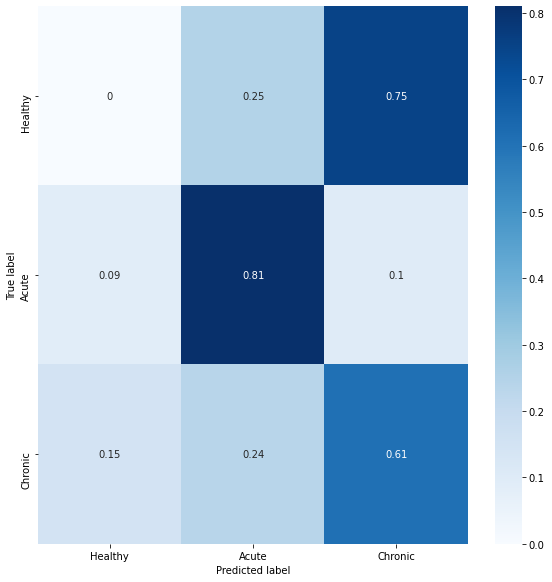

In [281]:
classes=['Healthy','Acute','Chronic']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

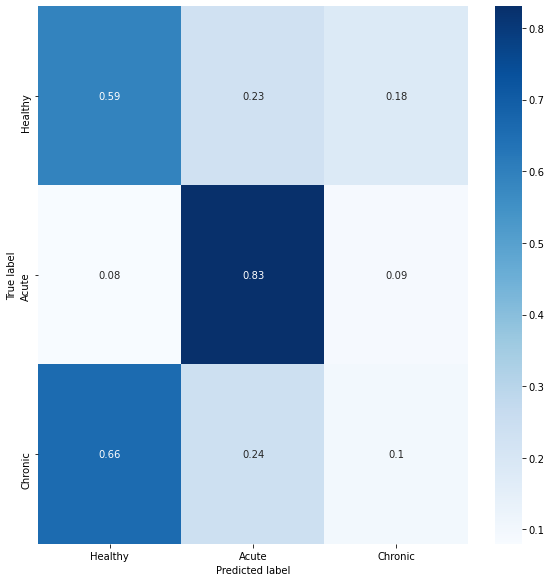

In [290]:
classes=['Healthy','Acute','Chronic']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [249]:
# pred = model.predict(loadTest(dataTrain)) 
# print(pred,(sci.special.softmax(pred,axis=1)) )
l

['1793_day8',
 '1222_day7',
 '4539_day15A',
 '1222_BaselineL',
 '1793_BaselineS',
 '7909_day8',
 '1208_day2',
 '8430_day35L',
 '0761_day19L',
 '7909_day10',
 '1236_day30A',
 '1208_BaselineS',
 '1236_day3',
 '1236_day1',
 '4539_day8',
 '1793_day6',
 '1231_BaselineL',
 '0761_day2',
 '8430_day3',
 '1208_BaselineL',
 '0761_day12',
 '4539_day6',
 '7909_day12',
 '1222_day15A',
 '1222_day9',
 '7909_day14',
 '1793_BaselineA',
 '1208_day14',
 '4539_day0',
 '1793_day15A',
 '7909_Baseline2A',
 '0761_BaselineS',
 '0761_day6',
 '1222_day5',
 '1793_day34L',
 '1222_day20L',
 '1208_day30A',
 '0761_day4',
 '1222_day3',
 '0761_day1',
 '1222_day32A',
 '1253_BaselineS',
 '1793_day12',
 '8430_day9',
 '4539_day14',
 '7909_day13',
 '1231_BaselineA',
 '1222_day2',
 '1793_day2',
 '0761_day31A',
 '4539_day12',
 '1793_day14',
 '8430_day19L',
 '7909_day0',
 '8430_day11',
 '1236_day35L',
 '1236_day9',
 '1208_day15A',
 '8430_BaselineS',
 '8430_BaselineL',
 '0761_day8',
 '1208_day12',
 '1236_day13',
 '8430_day5',
 '